# GCN Interpretability

### _Opening the black box_

<br>

**Author:** Marcel Baltruschat (<a href="https://github.com/mrcblt">@GitHub</a>)<br>
**Date:** 28.01.2022<br>
**License:** MIT
<br><br><br>

### Installation with Conda

```
conda create -n expl_gcn -c pyg -c pytorch -c conda-forge \
    python=3.9 pytorch=1.10 pyg captum jupyterlab matplotlib rdkit ipywidgets
```

---


### Imports and Settings

In [1]:
from collections import defaultdict as ddict
from statistics import mean

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from captum.attr import IntegratedGradients
from IPython.display import SVG, HTML
from ipywidgets import interact
from rdkit import Chem
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolDraw2DSVG, PrepareMolForDrawing
from torch.nn import Linear
from torch_geometric.datasets import TUDataset
from torch_geometric.nn.models import GNNExplainer
from torch_geometric.nn import GraphConv, global_mean_pool
from torch_geometric.utils import remove_self_loops

---
## Loading Example GCN Model and Dataset

##### The example model was generated by Son Ha ([Jupyter Notebook](https://github.com/czodrowskilab/5minfame/blob/95a4177a1e027587be74e3004cd1d5b6995eff4e/2022-01-21-Ha-PyG_Graph_Classification.ipynb)). The model was saved at the end of the notebook with the following code:
```python
torch.save(model, 'mutag_gcn_model.pt')
```
<br>

In [2]:
dataset = TUDataset(name='MUTAG', root='/tmp', use_node_attr=True)

# Get the same ording as during training
torch.manual_seed(12345)

dataset = dataset.shuffle()
test_dataset = dataset[150:]

In [3]:
print(f'Dataset: {dataset.name}')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of node features: {dataset.num_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Size of train dataset: {len(dataset) - len(test_dataset)}')
print(f'Size of test dataset: {len(test_dataset)}')

Dataset: MUTAG
Number of graphs: 188
Number of node features: 7
Number of edge features: 4
Number of classes: 2
Size of train dataset: 150
Size of test dataset: 38


<br>

#### Model Class by Son Ha

##### The class is needed for loading the model.

In [4]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [5]:
model = torch.load('mutag_gcn_model.pt')
model.eval()
model

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

---
## Look into the Model<br>

### Utils

The information about the performed one-hot encoding was extracted from the `README.txt` file included in the [dataset zip file](https://www.chrsmrrs.com/graphkerneldatasets/MUTAG.zip).

In [6]:
pt = Chem.GetPeriodicTable()

# One-hot encoded bond types as edge features
edge_ref = [BondType.AROMATIC,  # 0
            BondType.SINGLE,    # 1
            BondType.DOUBLE,    # 2
            BondType.TRIPLE]    # 3

# One-hot encoded elements as node features
node_ref = [pt.GetAtomicNumber('C'),   # 0
            pt.GetAtomicNumber('N'),   # 1
            pt.GetAtomicNumber('O'),   # 2
            pt.GetAtomicNumber('F'),   # 3
            pt.GetAtomicNumber('I'),   # 4
            pt.GetAtomicNumber('Cl'),  # 5
            pt.GetAtomicNumber('Br')]  # 6

In [7]:
def graph_to_mol(data, node_ref, edge_ref):
    """
    Converts a PyTorch graph to a RDKit molecule. Since no further information about
    other properties of the molecule like charges were provided, the resulting molecule
    may be chemically invalid.
    """
    if data.has_self_loops():
        data = data.clone()
        data.edge_index, data.edge_attr = remove_self_loops(data.edge_index, data.edge_attr)
    mol = Chem.RWMol()
    for node in data.x:
        mol.AddAtom(Chem.Atom(node_ref[node.argmax()]))
    seen = ddict(list)
    for i, (begin, end, attr) in enumerate(zip(*data.edge_index, data.edge_attr)):
        edge = tuple(sorted((int(begin), int(end))))
        if edge not in seen:
            mol.AddBond(*edge, edge_ref[attr.argmax()])
        seen[edge].append(str(i))
    for (begin, end), ix in seen.items():
        # Saving of the original edge_index ids for later usage
        mol.GetBondBetweenAtoms(begin, end).SetProp('edge_ix', ','.join(ix))
    mol.UpdatePropertyCache(strict=False)
    return mol

In [8]:
def visualize_in_molecule(mol, edge_mask, node_mask,
                          threshold=0.0, edge_func=mean, size=(300, 300),
                          kekulize=False, add_atom_numbers=False, alpha_offset=0.2,
                          rgb_color=(1.0, 0.0, 0.0)):
    """
    Returns an IPython SVG object containing the drawn molecule with atoms and
    bonds highlighted based on the specified parameters.
    """
    d2d = MolDraw2DSVG(*size)
    if not kekulize:
        d2d.drawOptions().prepareMolsBeforeDrawing = False
        mol = PrepareMolForDrawing(mol, kekulize=False)
    d2d.drawOptions().addAtomIndices = add_atom_numbers
    atoms = {}
    if node_mask is not None:
        for a in mol.GetAtoms():
            if node_mask[a.GetIdx()] > threshold:
                atoms[a.GetIdx()] = (*rgb_color, float(node_mask[a.GetIdx()]) - alpha_offset)
    bonds = {}
    if edge_mask is not None:
        for b in mol.GetBonds():
            eix = b.GetProp('edge_ix').split(',')
            mask = edge_func([float(edge_mask[int(i)]) for i in eix])
            if mask > threshold:
                bonds[b.GetIdx()] = (*rgb_color, mask - alpha_offset)
    d2d.DrawMolecule(mol,
                     highlightAtoms=atoms.keys(), highlightBonds=bonds.keys(),
                     highlightAtomColors=atoms, highlightBondColors=bonds)
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

<br>

### GNN Explainer

In [9]:
expl = GNNExplainer(model, epochs=300, log=False, return_type='raw', lr=0.01, feat_mask_type='scalar')
node_masks = []
edge_masks = []
molecules = []
for data in test_dataset:
    nm, em = expl.explain_graph(data.x, data.edge_index)
    node_masks.append(nm)
    edge_masks.append(em)
    molecules.append(graph_to_mol(data, node_ref, edge_ref))

#### Looking into the first test data entry

##### Visualizing the importancies in the graph

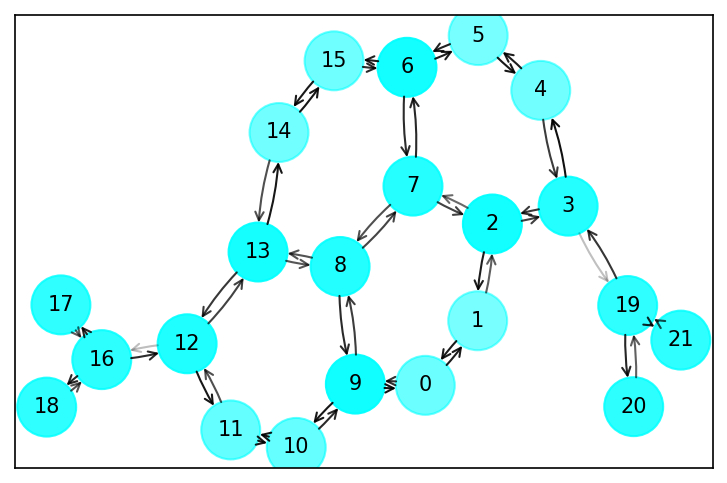

In [10]:
plt.figure(dpi=150)
expl.visualize_subgraph(-1, test_dataset[0].edge_index, edge_masks[0], seed=13, node_alpha=node_masks[0])
plt.show()

#### Not quite easy to interpret... Try to show it as molecules:

##### The molecules might be chemically invalid due to missing information in the graphs about e.g. charge states, ...

<br>

#### Nodes only

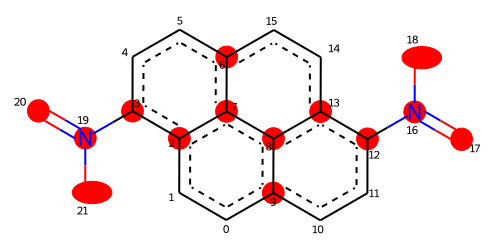

In [11]:
visualize_in_molecule(molecules[0], None, node_masks[0], 0.7, size=(500, 250), add_atom_numbers=True)

<br>

#### Problem: How to deal with the two edges between two nodes?

#### `edge_func=min`

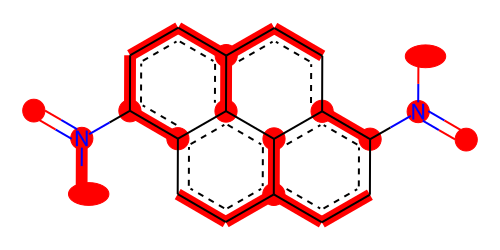

In [12]:
visualize_in_molecule(molecules[0], edge_masks[0], node_masks[0], 0.7, size=(500, 250), edge_func=min)

<br>

#### `edge_func=max`

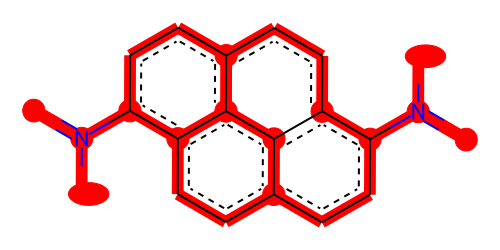

In [13]:
visualize_in_molecule(molecules[0], edge_masks[0], node_masks[0], 0.7, size=(500, 250), edge_func=max)

<br>

#### `edge_func=mean`

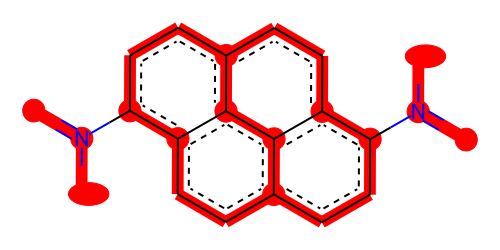

In [14]:
visualize_in_molecule(molecules[0], edge_masks[0], node_masks[0], 0.7, size=(500, 250), edge_func=mean)

<br>

---
### PyTorch Captum

##### Code was adapted from a [Google Colab notebook](https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing) from PyG

In [15]:
def model_forward(edge_mask, data, model):
    batch = torch.zeros(data.x.shape[0], dtype=int)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(data, model, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True)
    ig = IntegratedGradients(model_forward)
    mask = ig.attribute(input_mask, target=target,
                        additional_forward_args=(data, model),
                        internal_batch_size=data.edge_index.shape[1])
    edge_mask = np.abs(mask.detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [16]:
capt_edge_masks = []
for data in test_dataset:
    capt_edge_masks.append(explain(data, model, target=1))

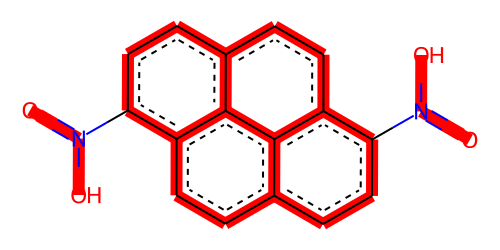

In [17]:
visualize_in_molecule(molecules[0], edge_masks[0], None, 0.6, size=(500, 250))

<br>

---
### Interactive Widget for Comparison

In [18]:
def show_both(test_data_id):
    expl = visualize_in_molecule(molecules[test_data_id], edge_masks[test_data_id], node_masks[test_data_id], threshold=0.7, size=(500, 300))
    capt = visualize_in_molecule(molecules[test_data_id], capt_edge_masks[test_data_id], None, threshold=0.6, size=(500, 300))
    print(f'\nLeft: GNNExplainer (Threshold: 0.7)\nRight: PyTorch Captum (Threshold: 0.6)\nTrue Class: {int(test_dataset[test_data_id].y[0])}\n')
    return HTML('<div style="white-space: nowrap">{}{}</div>'.format(expl.data, capt.data))

In [19]:
interact(show_both, test_data_id=range(len(test_dataset)));

interactive(children=(Dropdown(description='test_data_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<br>

---
### Resources
- https://chrsmrrs.github.io/datasets/docs/datasets/ (Datasets)
- https://pytorch-geometric.readthedocs.io/en/latest/index.html (PyG)
- https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html (PyG Colab Notebooks)
- https://www.youtube.com/c/DeepFindr (Nice YouTube channel about (Explainable) AI)
- https://captum.ai/ (PyTorch Captum)

### Disclaimer
The configurations for modelling as well as the preprocessing might be suboptimal for the specific task and dataset. Since the key point of this notebook is to show an example of how to interpret a trained GCN, configuration and dataset optimisation was neglected. Also the shown molecules might not be chemically correct due to missing information about e.g. charge states, etc.